# Predict Immunization Dropouts

In this notebook, I give a summary of my analysis and thought process. My analysis can be divided into 5 main sections:

1. [Problem Outline](#1)
2. [Exploratory Data Analysis](#2)
3. [Model + Training](#3)
4. [Analysing Results](#4)
5. [Conclusion](#5)

In [1]:
# SETUP

#general imports
import numpy as np
import pandas as pd

#model training imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import model_selection

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import fbeta_score

#visualization imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

RND = 2019

Using TensorFlow backend.
/Users/rabiyanoori/miniconda3/envs/ds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/rabiyanoori/miniconda3/envs/ds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/rabiyanoori/miniconda3/envs/ds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/rabi

# 1. Define Problem<a id='1'></a>

- Goals: Maximize the amount of patients that complete their full vaccinations. 
- Type of problem: Supervised, classification, prediction
- Specific ML task: Classify the patients as (1) 'need intervention' and (0) 'don't need intervention'
- Evaluation Metric: ROC score
- False Negative vs False Positive: FN more costly than FP

# 2. Exploratory Data Analysis<a id='2'></a>

Refer to 1-exploratory-data-analysis.ipynb for data cleaning and analysis

First the data was cleaned by:
- removing duplicate values
- imputing missing data

Second, since the model had to predict which class the patients belong to, I annotated the data by assigning a class to each patients. This was done by determining which patients would NOT receive their full vaccination records by 6 months of age and classifying them as (1) 'need intervention', the remaining were classified as (0) 'don't need intervention'.

Finally a created a new data table "training_data" that contains data on patients only up to 4 months of age, with their class labels and categorical values transformed to one-hot-encoding. 

# 3. Model + Training<a id='3'></a>

#### Baseline Model

In [24]:
#load the processed data

data = pd.read_csv("proc_data/training_baseline.csv", na_filter = False)
data.head()

,pat_id,fac_id,gender,region,district,Y,n-opv,n-dtp
0,1,51.0,f,Ghanzi,Ghanzi,False,3,3
1,2,89.0,f,Chobe,Chobe,True,1,1
2,3,161.0,m,Central,Tutume,True,2,2
3,4,168.0,f,Central,Lethlakane,True,1,1
4,5,183.0,m,Central,Tuli,True,3,3


In [25]:
# as a baseline score lets predict to highed occuring class as prediction for all

# how many patients need intervention vs dont?
data.Y.value_counts()

True     31673
False    17102
Name: Y, dtype: int64

In [26]:
# baseline accuracy - if the model predicted everyone needs intervention:
31031/(31031+17102) * 100

64.46928302827581

In [69]:
# f0.5 score if the model predicted everyone needs intervention:

fbeta_score(data['Y'], data['Y'].copy(deep=True).replace(False,True), pos_label = True , beta=0)

0.6493695540748334

In [27]:
data.describe(include = "all")

,pat_id,fac_id,gender,region,district,Y,n-opv,n-dtp
count,48775.000000,48775,48775,48775,48775,48775,48775.000000,48775.000000
unique,NaN,346,3,16,25,2,NaN,NaN
top,NaN,NA,m,North-West,Ngamiland East,True,NaN,NaN
freq,NaN,2446,23931,16184,14523,31673,NaN,NaN
mean,25021.350118,NaN,NaN,NaN,NaN,NaN,2.635428,2.635428
std,14435.084986,NaN,NaN,NaN,NaN,NaN,0.968813,0.968813
min,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,12522.500000,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000
50%,25036.000000,NaN,NaN,NaN,NaN,NaN,3.000000,3.000000
75%,37522.500000,NaN,NaN,NaN,NaN,NaN,3.000000,3.000000


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48775 entries, 0 to 48774
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pat_id    48775 non-null  int64 
 1   fac_id    48775 non-null  object
 2   gender    48775 non-null  object
 3   region    48775 non-null  object
 4   district  48775 non-null  object
 5   Y         48775 non-null  bool  
 6   n-opv     48775 non-null  int64 
 7   n-dtp     48775 non-null  int64 
dtypes: bool(1), int64(3), object(4)
memory usage: 2.7+ MB


In [29]:
# convert categorical variables to one-hot-encoded

# Categorical boolean mask
categorical_feature_mask = data.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = data.columns[categorical_feature_mask].tolist()

categorical_cols

['fac_id', 'gender', 'region', 'district']

In [30]:
categorical_feature_mask

pat_id      False
fac_id       True
gender       True
region       True
district     True
Y           False
n-opv       False
n-dtp       False
dtype: bool

In [31]:
# generate binary values using get_dummies
data = pd.get_dummies(data, columns=categorical_cols)
data.head()

,pat_id,Y,n-opv,n-dtp,fac_id_1.0,fac_id_10.0,fac_id_100.0,fac_id_101.0,fac_id_102.0,fac_id_103.0,...,district_Ngamiland East,district_Ngamiland West,district_Ngwaketse North,district_Palapye,district_Selibe Phikwe,district_Serowe,district_South East,district_Tshabong,district_Tuli,district_Tutume
0,1,False,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,True,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,True,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,True,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,True,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [34]:
# split into train/test set
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['Y', 'pat_id']), 
                                                    data['Y'],
                                                    random_state=RND, 
                                                    stratify = data['Y'])

In [46]:
model = Sequential()

model.add(Dense(392, input_dim=392, activation='relu',
                kernel_regularizer=regularizers.L1L2(l1=0.0, l2=0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
36581/36581 [==============================] - 8s 207us/step - loss: 1.3831 - accuracy: 0.7366
Epoch 2/5
36581/36581 [==============================] - 6s 155us/step - loss: 0.5168 - accuracy: 0.7423
Epoch 3/5
36581/36581 [==============================] - 6s 174us/step - loss: 0.5183 - accuracy: 0.7392
Epoch 4/5
36581/36581 [==============================] - 7s 182us/step - loss: 0.5150 - accuracy: 0.7400
Epoch 5/5
36581/36581 [==============================] - 6s 162us/step - loss: 0.5162 - accuracy: 0.7408


In [47]:
y_test_pred = model.predict_classes(X_test)

In [60]:
fbeta_score(y_test, y_test_pred, pos_label = True , beta=0.5)

0.8007031921890019

In [59]:
fbeta_score(y_test, all_true_pred, pos_label = True , beta=0.5)

0.6983102268317636

In [54]:
all_true_pred = y_test.copy(deep=True)

In [57]:
all_true_pred.replace(False,True, inplace= True)
all_true_pred

27255    True
34522    True
35790    True
13308    True
3719     True
         ... 
18749    True
29       True
2053     True
32440    True
45940    True
Name: Y, Length: 12194, dtype: bool

#### Random Forests Model

In [61]:
clf = RandomForestClassifier(random_state=RND, class_weight = 'balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=2019)

In [62]:
y_test_pred = clf.predict(X_test)

In [71]:
fbeta_score(y_test, y_test_pred, pos_label = True , beta=0.5)

0.8164451332180962

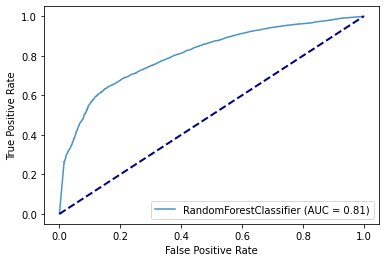

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
ax = plt.gca()
rfc_disp = plot_roc_curve(clf, X_test, y_test, ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

In [74]:
svc_disp = plot_roc_curve(model, X_test, y_test)


ValueError: Sequential should be a binary classifier